# Linear Regression

by Amir Hossein A. Rahnama

Last run of the notebook: 

In [1]:
import time
import datetime

datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S')

'2019-10-17 11:22:42'

In this notebook, we replicate the example from Elements of Statistical Learning by Jerome H. Friedman, Robert Tibshirani, and Trevor Hastie (section 3.2.1).

We will be coding everything from scratch but in order to check our solution, we will be using Scikit Learn and StatsModels. 

As a personal preference, I would like to load all my modules at the top of my notebook. This makes it clear to the reader what type of libraries and what installations are needed.

**NOTE**: You need to run this notebook with Python 3+ only!

In [2]:
%load_ext memory_profiler

In [3]:
import sys
if sys.version_info[0] < 3:
    raise Exception("Must be using Python 3")

In [4]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from memory_profiler import profile
from sklearn.datasets.samples_generator import make_regression
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

Let's load the data from the exampe:

In [5]:
X = pd.read_csv('http://statweb.stanford.edu/~tibs/ElemStatLearn/datasets/prostate.data', sep='\t', usecols=range(1, 11))

The data comes with its own training/test split. Let us divide the data:

In [6]:
X_train = X[X['train'] == 'T']
y_train = X_train['lpsa']
X_train = X_train.drop(columns=['lpsa', 'train'], axis=1)

X_test = X[X['train'] == 'F']
y_test = X_test['lpsa']
X_test = X_test.drop(columns=['lpsa', 'train'], axis=1)

Let us look at histograms of each variable: 

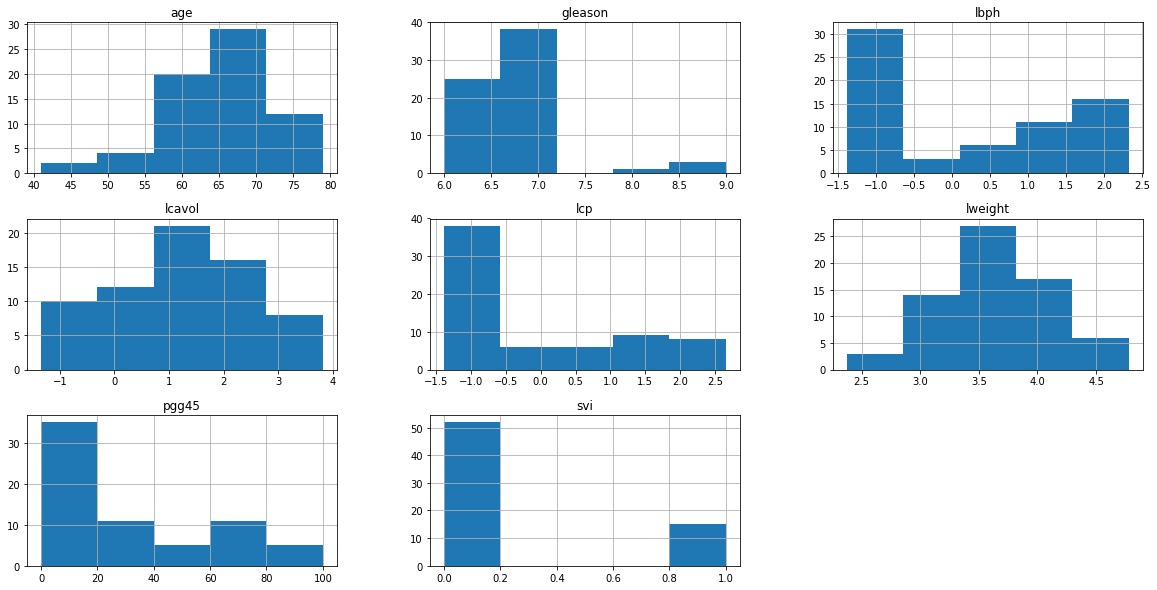

In [24]:
his = X_train.hist(figsize=(20,10), bins=5)

We need to normalize the predictors before fitting the model as mentioned in the book. It usually is a nice practice if you are not changing the distribution of your values, but basically aligning the center of all distibutions:

In [8]:
normalized_X_train=(X_train - X_train.mean(axis=0))/X_train.std(axis=0)

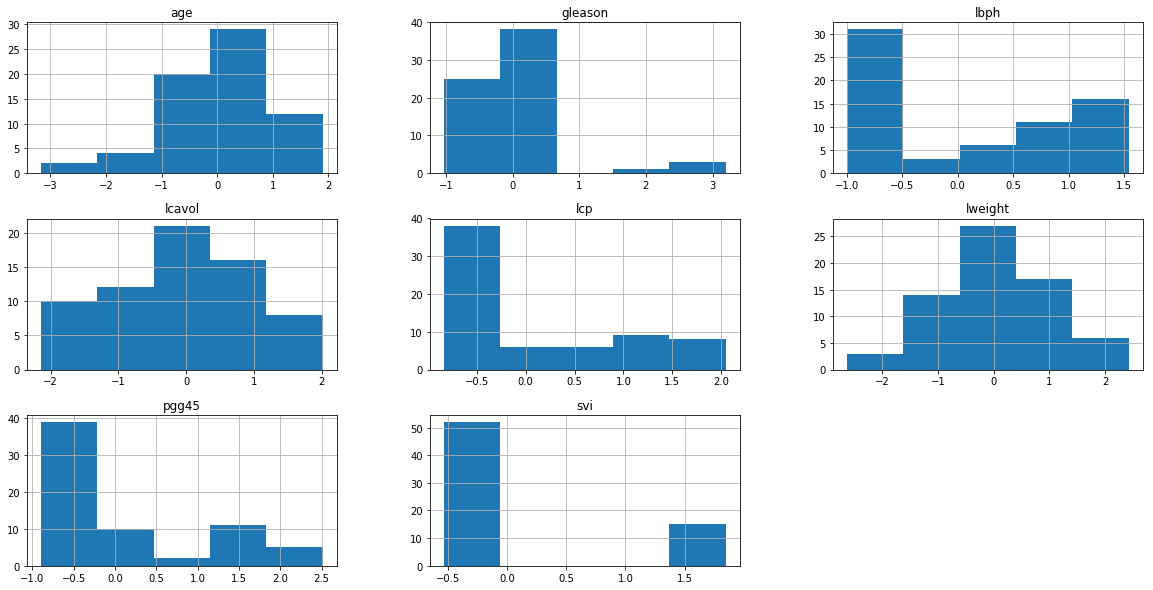

In [9]:
his_normalize = normalized_X_train.hist(figsize=(20,10), bins=5)

In [10]:
reg = LinearRegression(normalize=True).fit(normalized_X_train, y_train)

print('Intercept: {:6.3f}'.format(reg.intercept_))
for i, col in enumerate(X_train.columns):
    print('{:9s}: {:6.3f}'.format(col, reg.coef_[i]))

Intercept:  2.452
lcavol   :  0.716
lweight  :  0.293
age      : -0.143
lbph     :  0.212
svi      :  0.310
lcp      : -0.289
gleason  : -0.021
pgg45    :  0.277


### Ordinary Least Squares (OLS)

Okay, now we have used Scikit Learn's library to calculate the weights of the model. Scikit Learn performs OLS on the model. In here, we calculate the same weights ourselves and take things ever further. First and foremost, OLS assums that in your data matrix, namely $X$, you have included the bias (or the intercept). 

In [11]:
normalized_X_train.insert(0, "intercept", np.ones(normalized_X_train.shape[0]))

OLS basically calculates $(X^TX)^{-1}X^T y$:

In [12]:
def OLS(_x, _y):
    _x_t = _x.T
    x_power_2 = np.matmul(_x_t, _x)
    inv_x_power_2 =  np.linalg.inv(x_power_2)
    inv_x_t = np.matmul(inv_x_power_2, _x_t) 
    w_hat = np.matmul(inv_x_t, _y)
    
    return w_hat

Using the values of $w$ found by OLS, we can calculate $\hat{y} = \hat{W} X$:

In [13]:
def _predict(_x, _w_hat):
    return np.matmul(_x, _w_hat) 

And Residual Sum of Sqaures (RSS) is calculated by $\sum_{i=1}^{N} (\hat{y} - y)^2$:

In [14]:
def RSS(y_hat, y_true):
    return np.sum(np.power(y_hat - y_true, 2), axis=0) 

### Sampling properties

In [15]:
w_hat = OLS(normalized_X_train.values, y_train) 

y_train_hat = _predict(normalized_X_train.values, w_hat)
sigma_hat = RSS(y_train, y_train_hat)/(normalized_X_train.shape[0] - normalized_X_train.shape[1] - 1)
var_w_hat = np.diagonal(np.linalg.inv(np.matmul(normalized_X_train.values.T, normalized_X_train.values)) * sigma_hat)
z_score = w_hat / np.sqrt(sigma_hat) * np.sqrt(var_w_hat)

In [16]:
print('\t \t  coef \t\t  std error \t z-score')
for i, col in enumerate(normalized_X_train.columns):
    print('{:9s} \t {:6.3f} \t {:6.3f}  \t {:6.3f}'.format(col, w_hat[i], np.sqrt(var_w_hat[i]), z_score[i]))

	 	  coef 		  std error 	 z-score
intercept 	  2.452 	  0.088  	  0.300
lcavol    	  0.716 	  0.135  	  0.134
lweight   	  0.293 	  0.107  	  0.044
age       	 -0.143 	  0.103  	 -0.020
lbph      	  0.212 	  0.104  	  0.031
svi       	  0.310 	  0.126  	  0.055
lcp       	 -0.289 	  0.156  	 -0.063
gleason   	 -0.021 	  0.144  	 -0.004
pgg45     	  0.277 	  0.161  	  0.062


Let's compare the result with standard packages:

In [17]:
X_train_norm = (X_train - X_train.mean(axis=0))/X_train.std(axis=0)
result = sm.OLS(y_train, sm.add_constant(X_train_norm)).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   lpsa   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     16.47
Date:                Thu, 17 Oct 2019   Prob (F-statistic):           2.04e-12
Time:                        11:22:46   Log-Likelihood:                -67.505
No. Observations:                  67   AIC:                             153.0
Df Residuals:                      58   BIC:                             172.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4523      0.087     28.182      0.0

/home/amir/anaconda3/envs/dl/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### Model selection using F-statistic and ANOVA

If we assume the Statistical significance threshold of $\alpha = 0.5$, a Z-score with absolute value of greater than 2 is significat.  

In [18]:
_normalized_X_train = normalized_X_train.copy()
_normalized_X_train = _normalized_X_train.drop(['age', 'lcp', 'gleason', 'pgg45'], axis=1)

In [19]:
_normalized_X_train.shape

(67, 5)

In [20]:
w_hat_smaller_model = OLS(_normalized_X_train.values, y_train)
y_hat_smaller_model = _predict(_normalized_X_train.values, w_hat_smaller_model)

rss_0 = RSS(y_hat_smaller_model, y_train)
rss_1 = RSS(y_train_hat, y_train)

p_1 = normalized_X_train.shape[1]
p_0 = _normalized_X_train.shape[1]
N = normalized_X_train.shape[0]

In [21]:
f_statistic_enu = (rss_0-rss_1)/(p_1-p_0)
f_statistic_deno = (rss_1) / (N - p_1)

In [22]:
f_statistic = f_statistic_enu/ f_statistic_deno
f_statistic

1.6697548846375232

### Significance tests:

Use the f-statistic to calculate the CDF of the F distribution to see if the smaller model is any better or not (Null hypothesis is that the smaller model outperforms the original model): 

In [23]:
import scipy
p_value = scipy.stats.f.cdf(f_statistic, 4, 58)

if (1 - p_value <= 0.05):
    print('The null hypothesis can be rejected')
else:
    print('The evidence is not strong enough')

The evidence is not strong enough


As we can see, we do not have enough evidence to believe the smaller model is better than the original model. You can further experiment with removing different subsets of features and see if the results differ ot not.

### Weakness of OLS

If you have paid enough attention to OLS solution, you can see that it requires the calculation of the inverse matrix of the data, namely $X^{-1}$. There are two limitations with OLS approach: 

What if the inverse if not computable? Meaning that
* If the matrix is not square?
* If the matrix's determinant is equal to zero (a singular matrix)?
* If the matrix is too big to be stored in the memory?
* What if it does not satisfy the requirements of OLS (see Lecture slides)

Then we need to consider iterative methods that will be discussed later.